# Box pendulum
- This is modelling for the rotary pendulum
- $m_P$ is the mass of the pendulum
- $m_A$ is the mass of the Arm
- $\theta$ is the angle made by the arm from the principal axis
- $\alpha$ is the angle made by the pendulum from the z axis of the arm

## Motor Parameters

In [1]:
mar = 0.095 #kg
lar = 0.085 #m
mpr = 0.024 #kg
lpr = 0.129 #m

# Motor Parameters
V_nom = 18.0       # Nominal input voltage (V)
tau_nom = 22.0/1000     # Nominal torque (mN-m) (Note: Convert to N-m)
omega_nom = 3050   # Nominal speed (RPM)
I_nom = 0.54       # Nominal current (A)
R_m = 8.4          # Terminal resistance (Ohms)
k_t = 0.042        # Torque constant (N-m/A)
k_m = 0.042        # Motor back-emf constant (V/(rad/s))
J_m = 0.000004     # Rotor inertia (kg-m^2)
L_m = 1.16e-3      # Rotor inductance (H)

# torque and voltage
# def calculate_torque_voltage(th, dth, ddth, J_arm):
#     # Step 1: Combine the motor's rotor inertia and the arm's inertia
#     J_total = J_m + J_arm
    
#     # Step 2: Calculate the required torque to rotate the arm (from acceleration)
#     torque = J_total * ddth  # Torque based on combined inertia and angular acceleration
    
#     # Step 3: Calculate the current required for the torque
#     current = torque / k_t
    
#     # Step 4: Calculate the motor's voltage, including the back-emf term
#     voltage = current * R_m + k_m * dth  # Voltage = IR + back-emf
    
#     return torque, voltage

def calculate_torque_voltage(i, m):
    # Step 1: Combine the motor's rotor inertia and the arm's inertia
    J_total = value(m.In[1]) + J_m
    
    # Step 2: Calculate the required torque to rotate the arm (from acceleration)
    if i > 1:
        torque = J_total * value(m.ddth[i, 1])
    else:
        torque = 0  # or some initial value
    
    # Step 3: Calculate the current required for the torque
    current = torque / k_t
    
    # Step 4: Calculate the motor's voltage, including the back-emf term
    if i > 1:
        voltage = current * R_m + k_m * value(m.dth[i, 1])
    else:
        voltage = 0  # or some initial value
    
    return torque, voltage


## Rotation Matrices and functions

In [2]:
# Rotation matrices
import sympy as sym
import numpy as np
from IPython.display import display #for pretty printing
import csv

# Define the rotation matrices as functions, counterclockwise rotation
# axes system is defined similar to the one used for making the 3d plots
def rotX(th):
    return sym.Matrix([ [1.0,         0.0,          0.0],
                        [0.0, sym.cos(th), -sym.sin(th)],
                        [0.0, sym.sin(th),  sym.cos(th)]])

def rotY(th):
    return sym.Matrix([ [ sym.cos(th), 0.0, sym.sin(th)],
                        [ 0.0,         1.0,         0.0],
                        [-sym.sin(th), 0.0, sym.cos(th)]])

def rotZ(th):
    return sym.Matrix([ [sym.cos(th), -sym.sin(th), 0.0],
                        [sym.sin(th),  sym.cos(th), 0.0],
                        [0.0,    0.0,               1.0]])

## Dynamic Model

In [3]:
# create symbolic variables

# system parameters
X0, Y0, Z0 = sym.symbols(['X0','Y0', 'Z0']) # fixed position of Arm
g = sym.symbols('g')

mH, Lh, InH = sym.symbols(['m_H', 'l_H', 'I_H']) # Hub
mA, La, InA = sym.symbols(['m_A', 'l_A', 'I_A']) # Arm
mP, Lp, InP = sym.symbols(['m_P', 'l_P', 'I_P']) # Pen

# generalized coordinates
th, dth, ddth       = sym.symbols(['\\theta', '\\dot{\\theta}', '\\ddot{\\theta}'])
alph, dalph, ddalph = sym.symbols(['\\alpha', '\\dot{\\alpha}', '\\ddot{\\alpha}'])

q   = sym.Matrix([  [th],  [alph]]) #group into matrices
dq  = sym.Matrix([ [dth], [dalph]])
ddq = sym.Matrix([[ddth],[ddalph]])

display(ddq) #display prints it as cool latex stuff

# Rotation Matrices
R01 = rotZ(th)
R10 = R01.T

R12 = rotX(alph)
R21 = R12.T

R02 = R12*R01
R20 = R02.T

# Positions-----------------------------------------------
##### Arm is at the origin so no need for X0 and Y0
r_Hub_1 = sym.Matrix([0, 0, 0])
r_Hub   = R10*r_Hub_1

r_Arm_1 = sym.Matrix([La*0.5, 0, 0])
r_Arm   = R10*r_Arm_1

r_Pen_2 = sym.Matrix([0, 0, Lp*0.5]) # when alpha = 0 it should be upright which is the case here
r_Pen   = r_Arm*2 + R20*r_Pen_2
display(r_Arm, r_Pen)

# Velocities-------------------------------------------------
## Linear
dr_Arm = sym.simplify(r_Arm.jacobian(q)*dq)
dr_Pen = sym.simplify(r_Pen.jacobian(q)*dq)
dr_Hub = sym.simplify(r_Hub.jacobian(q)*dq)
#display(dr_Arm,dr_Pen)

## Angular
wHub = sym.Matrix([0, 0, dth])
wArm = sym.Matrix([0, 0, dth])
wPen = R12*wArm + sym.Matrix([dalph, 0, 0])

#display(wArm, wPen)

# Energies
## Kinetic energies
Ek = lambda m, dr, w, In: (0.5*m*dr.T*dr) + (0.5*In*w.T*w)
THub = Ek(mH, dr_Hub, wHub, InH)
TArm = sym.simplify(Ek(mA, dr_Arm, wArm, InA))
TPen = sym.simplify(Ek(mP, dr_Pen, wPen, InP))
T = sym.Matrix([sym.simplify(TArm + TPen)])
#display(THub, TArm, TPen, T)

## Potential energies
VArm = 0
VHub = 0
VPen = mP*g*r_Pen[2]
V = sym.Matrix([sym.simplify(VArm + VHub + VPen)])
#display(V)

Matrix([
[\ddot{\theta}],
[\ddot{\alpha}]])

Matrix([
[ 0.5*l_A*cos(\theta)],
[-0.5*l_A*sin(\theta)],
[                   0]])

Matrix([
[ 1.0*l_A*cos(\theta) + 0.5*l_P*sin(\alpha)*sin(\theta)],
[-1.0*l_A*sin(\theta) + 0.5*l_P*sin(\alpha)*cos(\theta)],
[                                   0.5*l_P*cos(\alpha)]])

## Forces and Torques

In [4]:
# forces & torques
tau = sym.symbols('\\tau')

Qtau = sym.Matrix([[tau],[0]]) # Torque tau acts in the th1 direction

Qtot = Qtau
Qall = Qtau
# ------------------------------------------------------------------------------------------------------------------

Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = T.jacobian(q) # partial of T in q

# term 4
Lg4 = V.jacobian(q) # partial of U in q

# put it all together
EOM = Lg1 - Lg3 + Lg4 - Qall.transpose()

EOM[1].simplify()

\ddot{\alpha}*(1.0*I_P + 0.25*l_P**2*m_P) - 0.5*\ddot{\theta}*l_A*l_P*m_P*cos(\alpha) - 0.125*\dot{\theta}**2*l_P**2*m_P*sin(2*\alpha) - 0.5*g*l_P*m_P*sin(\alpha)

# Pyomo stuff

In [5]:
# %reset # clears variables in workspace

# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# other
import sympy as sym
import numpy as np

from IPython.display import display #for pretty printing

# create the model
m = ConcreteModel()

In [6]:
N = 100 # how many points are in the trajectory
m.N = RangeSet(N) # For defining ordered/numerical sets. Works like 'range' in python.
m.L = RangeSet(2)


# Parameters
m.g = Param(initialize = 9.81)
m.X0 = Param(initialize = 0.0) # position of fixed base
m.Y0 = Param(initialize = 0.0)
m.Z0 = Param(initialize = 0.0)
m.h = Param(initialize = 0.02) # time step

# m.m = Param(m.L, initialize = 1.0) # mass of links
# m.len = Param(m.L, initialize = 1.0) # length of links
m.m = Param(m.L, initialize={1: 0.095, 2: 0.024})  # mass of links (kg)
m.len = Param(m.L, initialize={1: 0.085, 2: 0.129})  # length of links (m)

# Print the mass values for each link
for link in m.L:
    print(f"Link {link}: Mass = {m.m[link]}, Length = {m.len[link]}")

# IMPORTANT make sure your values are declared as floats: many a long debugging session has eventually led me to find something
# unexpectedly has a value of zero because of integer devision gone wrong. Goddamn implicit typing fuuuuuuuuuuuuuuuuuuuuuuuuuuu

# function for calculating moment of intertia from mass and length
calculate_In = lambda m, l: m.m[l]*m.len[l]**2/12
# m here is a local variable: the model given as input to the function, not necessarily our global model 'm'
# l is just an iterator: it doesn't have to have the same name as the set 

m.In = Param(m.L, initialize = calculate_In) # moment of inertia

# Variables
m.th   = Var(m.N, m.L) # position
m.dth  = Var(m.N, m.L) # velocity
m.ddth = Var(m.N, m.L) # acceleration

m.Tc = Var(m.N) # torque


# Integration constraints
def BwEuler_p(m,n,l): # for positions
    if n > 1:
        return m.th[n,l] == m.th[n-1,l] + m.h*m.dth[n-1,l]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.L, rule = BwEuler_p)

def BwEuler_v(m,n,l): # for velocities
    if n > 1:
        return m.dth[n,l] == m.dth[n-1,l] + m.h*m.ddth[n-1,l]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.L, rule = BwEuler_v)

# EOM stuff
EOM[1].simplify()

Link 1: Mass = 0.095, Length = 0.085
Link 2: Mass = 0.024, Length = 0.129


\ddot{\alpha}*(1.0*I_P + 0.25*l_P**2*m_P) - 0.5*\ddot{\theta}*l_A*l_P*m_P*cos(\alpha) - 0.125*\dot{\theta}**2*l_P**2*m_P*sin(2*\alpha) - 0.5*g*l_P*m_P*sin(\alpha)

In [7]:
#Lambdify the EOM
func_map = {'sin':sin, 'cos':cos} 

sym_list = [X0, Y0, Z0, g,
           th, alph, dth, dalph, ddth, ddalph, tau,
           mA, mP, La, Lp, InA, InP] # list of the symbols that will be substituted with inputs

lambEOM = {} # dictionaries are honestly my favourite thing about Python
for i in range(1,3): 
    lambEOM[i] = sym.lambdify(sym_list,EOM[i-1],modules = [func_map])
# We can contain the EOMs for all coordinates in a dictionary so we just need one constraint definition for the dynamics.

#create the dynamic constraints
def dynamics(m,n,l): # for theta1
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.X0, m.Y0, m.Z0, m.g, 
               m.th[n,1], m.th[n,2], m.dth[n,1], m.dth[n,2], m.ddth[n,1], m.ddth[n,2], m.Tc[n],
               m.m[1], m.m[2], m.len[1], m.len[2], m.In[1], m.In[2]] 
    return lambEOM[l](*var_list) == 0
m.dynamics = Constraint(m.N, m.L, rule = dynamics)

In [8]:
def CostFun(m):
    torque_sum = 0
    for n in range(1,N+1):
            torque_sum += m.Tc[n]**2
    return torque_sum
m.Cost = Objective(rule = CostFun)

# variable bounds
# In Pyomo, all variables are individual objects, so you have to use a loop to bound them.
# (If all the bounds are the same, you can set up a default bound when you create the variable, though)

# for n in range(1,N+1):
#     m.Tc[n].setlb(-50) 
#     m.Tc[n].setub(50)
# bounding actuator forces is tricky. It's usually a good idea, but if your cost function penalizes large forces as is 
# the case here, you might have an easier time finding a solution without doing so.
    
    # for l in range(1,3):
    #     m.th[n,l].setlb(-np.pi*2) #lower bound
    #     m.th[n,l].setub(np.pi*2) #upper bound
    
bounds = {1: (-np.pi/2, np.pi/2), # Link 1 bounds
          2: (-np.pi*2, np.pi*2)} # link 2 bounds

for n in range(1, N+1):
    for link, (lb, ub) in bounds.items():
        m.th[n, link].setlb(lb)
        m.th[n, link].setub(ub)

In [9]:
# initialization
# I'd suggest leaving out random initialization until you know your model converges. 
# The default null guess usually converges more easily.

# for n in range(1,N+1):
#     m.Tc[n].value = np.random.uniform(-0.1,0.1)
    
#     for l in range(1,3):
#         #m.th[n,l].value = np.random.uniform(-0.1,0.1)
#         m.dth[n,l].value = np.random.uniform(-0.1,0.1)
#         m.ddth[n,l].value = np.random.uniform(-0.1,0.1)

In [14]:
# Boundary conditions
# you should to do these after initialization so the values you want to be fixed don't accidentally end up being changed

# Initial conditions
m.th[1, 2].fix(0)
m.th[1, 1].fix(0)

# final conditions
m.th[N, 2].fix(np.pi) # final angle position (upright)
m.dth[N, 1].fix(0)    # final speed (0)
m.dth[N, 2].fix(0)    # final acceleration (0)

In [15]:
# solving
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt

# If you've managed to install your own version of ipopt, you can call it like:
#opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Stacey/CoinIpopt/build/bin/ipopt.exe')
#opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["print_level"]  = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"]     = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 300 # maximum cpu time in seconds
opt.options["Tol"]          = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = True) 

Ipopt 3.14.13: print_level=5
max_iter=30000
max_cpu_time=300
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     2173
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      884

Total number of variables............................:      695
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      197
                     variables with only upper bounds:        0
Total number of equa

In [16]:
# For debugging:
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

# If you want a full print-out of everything going on with your model, use:
#m.pprint() 

# This is your best friend when it comes to figuring out why something's not converging, why the solution looks weird, etc.
# It's probably most handy if you print it to a file:
#instance.pprint(filename='blah.txt')

# You can also pretty print individual elements of the model. e.g.
#m.th.pprint()

# export trajectories
def write_trajectory_to_csv(m, filename, decimal_places=6):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        
        # Write header
        writer.writerow(['Time', 'Arm Angle', 'Pendulum Angle', 'Arm Velocity', 'Pendulum Velocity'])
        
        for n in m.N:
            torque, voltage = calculate_torque_voltage(n, m)
            row = [
                round(m.h.value * (n-1), decimal_places),  # Time
                round(m.th[n, 1].value, decimal_places),   # Arm angle (theta)
                round(m.th[n, 2].value, decimal_places),   # Pendulum angle (alpha)
                round(m.dth[n, 1].value, decimal_places),  # Arm angular velocity
                round(m.dth[n, 2].value, decimal_places),  # Pendulum angular velocity
            ]
            writer.writerow(row)
# def write_trajectory_to_csv(m, filename, decimal_places=6):
#     with open(filename, 'w', newline='') as file:
#         writer = csv.writer(file)
        
#         # Write header
#         writer.writerow(['Time', 'Arm Angle', 'Pendulum Angle', 'Arm Velocity', 'Pendulum Velocity', 'Control Torque', 'Voltage'])
        
#         # Calculate arm inertia (J_arm)
#         J_arm = m.m[1] * (m.len[1]/2)**2  # Assuming arm rotates around its center
        
#         for n in range(2, len(m.N) + 1):  # Start from 2 to have a previous state
#             # Get current and previous state values
#             th_prev = m.th[n-1, 1].value
#             th_curr = m.th[n, 1].value
#             dth_prev = m.dth[n-1, 1].value
#             dth_curr = m.dth[n, 1].value
            
#             # Calculate torque and voltage
#             torque, voltage = calculate_torque_voltage(th_prev, th_curr, dth_prev, dth_curr, m.h.value, J_arm)

#             row = [
#                 round(m.h.value * (n-1), decimal_places),  # Time
#                 round(th_curr, decimal_places),            # Arm angle (theta)
#                 round(m.th[n, 2].value, decimal_places),   # Pendulum angle (alpha)
#                 round(dth_curr, decimal_places),           # Arm angular velocity
#                 round(m.dth[n, 2].value, decimal_places),  # Pendulum angular velocity
#                 round(torque, decimal_places),             # Calculated torque
#                 round(voltage, decimal_places),            # Calculated voltage
#             ]
#             writer.writerow(row)

# # Usage:
write_trajectory_to_csv(m, 'trajectory_1.csv', decimal_places=4)

ok
optimal


# Animate

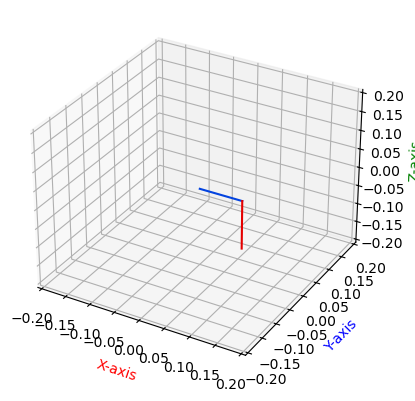

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

# Create the figure and subplots for XY, XZ, YZ planes, and a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # 3D plot

def plot_pendulum(i, m):  
    # Clear previous plots
    ax.clear()
    
    # Set limits and titles for each axis
    lim = 0.2
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.set_zlim([-lim, lim])
    ax.set_xlabel('X-axis', color='red')
    ax.set_ylabel('Y-axis', color='blue')
    ax.set_zlabel('Z-axis', color='green')
    ax.grid(True)

    # Calculate positions for the pendulum
    L1bottomx = m.X0.value + m.len[1] * np.cos(m.th[i,1].value)
    L1bottomy = m.Y0.value - m.len[1] * np.sin(m.th[i,1].value)
    L1bottomz = m.Z0.value

    L2bottomx = L1bottomx - m.len[2] * np.sin(m.th[i,1].value) * np.sin(m.th[i,2].value)
    L2bottomy = L1bottomy - m.len[2] * np.sin(m.th[i,1].value) * np.cos(m.th[i,2].value)
    L2bottomz = L1bottomz - m.len[2] * np.cos(m.th[i,2].value)

    # Plot in 3D
    ax.plot([m.X0.value, L1bottomx], [m.Y0.value, L1bottomy], [m.Z0.value, L1bottomz], color='xkcd:blue')
    ax.plot([L1bottomx, L2bottomx], [L1bottomy, L2bottomy], [L1bottomz, L2bottomz], color='xkcd:red')

# Update function for the animation
update = lambda i: plot_pendulum(i, m)

# Create animation
animate = ani.FuncAnimation(fig, update, range(1,N+1), interval=50, repeat=True)

# Embed the animation in the notebook
HTML(animate.to_html5_video())
